# Preprocessing EMG data with MUniverse

This notebook demonstrates how EMG data is preprocessed in MUniverse to make EMG recordings decomposition ready.

Users can thereby select between different filter types that are showcased in the following.

This includes different types of bandpass and notch filters.   

All these options can be used within MUniverse's nativly implemented decomposition pipelines. However, you can also pre-process you data with your own scripts and turn off the build in pre-processing steps. 

## Tutorial example 

We will first motivate the use of digital filters for pre-processing by inspecting and processing a single recording.

Before starting the actual investigation, we will import some essential dependencies and define some helper function helping us analyzing the data. 

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from muniverse.algorithms.core import bandpass_signals, notch_signals
from muniverse.utils.data2bids import bids_emg_recording, edf_to_numpy

from pathlib import Path
from IPython.display import display

In [ ]:
from scipy.signal import welch

def calc_PSD(sig, fsamp=2048, nperseg=2048, noverlap=2048/2):
    '''
    Compute the power spectral density for each channel using Welch's method.

    Args:
        sig (ndarray): Multi-channel signal (Channels x Samples)
        fsamp (float): Sampling rate in Hz
        nperseg (int): Number of data points per segment
        overlap (int): Number of overlapping samples
    '''

    f, _ = welch(sig[0,:], fs=fsamp, nperseg=nperseg, noverlap=noverlap)

    P = np.zeros((sig.shape[0], f.shape[0]))

    for i in range(sig.shape[0]):
        _ , P[i,:] = welch(sig[i,:], fs=fsamp, nperseg=nperseg, noverlap=noverlap)

    return P, f


#### Loading some test data

We will select one of the experimental recordings (Avrillon et al 2024) from the MUniverse dataset collection.

You can download it from Dataverse: https://doi.org/10.7910/DVN/L9OQY7

Having this BIDS-EMG dataset on the harddrive we can import it into this workspace. This will not only allow us to load the data, but also all relevant recording metadata that is needed to process the data:

- Here, the most important recoring metadata is the sampling rate, the local power line frequency and the number of EMG channels.
- To get a better idea on the recording we will also quickly inspect the channel specific metadata, e.g., showing which channels contain non EMG data such as the requested and perfomed torque in the given isometric task. 
- Latsly, we convert the EDF data into numpy arrays for further processing. 

In [ ]:
# Load a BIDS recording stored on your hard drive.
emg_recording = bids_emg_recording(
    subject=13,
    task="isometric20percentmvc",
    datasetname="Avrillon_et_al_2024", 
    root=str(Path.home()) + "/Documents/muniverse-data/Datasets/"
)
emg_recording.read()

# Extract some recording metadata
nchan = emg_recording.emg_sidecar["EMGChannelCount"]    # Number of EMG channels
fsamp = emg_recording.emg_sidecar["SamplingFrequency"]  # Sampling rate in Hz    
pfreq = emg_recording.emg_sidecar["PowerLineFrequency"] # Power line frequency in Hz

# Show the channel the channel sidecar
cols = ["name", "type", "unit", "group", "target_muscle", "grid_name"]
print(emg_recording.channels.loc[:, cols].head().to_string())
print("...")
print(emg_recording.channels.loc[:, cols].tail().to_string())
#display(emg_recording.channels.head())

# Now we convert the raw EDF to numpy arrays
idx = np.arange(emg_recording.emg_data.num_signals)
data = edf_to_numpy(emg_recording.emg_data,idx).T

emg_data = data[1:nchan,:]
requested_path = data[256,:]
performed_path = data[257,:]

nsamples = emg_data.shape[1]



   name type unit  group     target_muscle   grid_name
0  Ch01  EMG   mV  Grid1  Vastus Lateralis  GR08MM1305
1  Ch02  EMG   mV  Grid1  Vastus Lateralis  GR08MM1305
2  Ch03  EMG   mV  Grid1  Vastus Lateralis  GR08MM1305
3  Ch04  EMG   mV  Grid1  Vastus Lateralis  GR08MM1305
4  Ch05  EMG   mV  Grid1  Vastus Lateralis  GR08MM1305
...


#### Raw data inspection

Next we will try to get a fisrt impression on the EMG data we have just imported. This involves:

- Visual inspection of a few arbitray channels from this recording together with the perfomed and requsted torque trajetory.
- Split up the signal into a noise recording (no muscle activity) and the actual signal stemming from muscle contraction, to compute
    - The signal to noise ration (in dB)
    - The root-mean-square (RMS) value of the noise 
- Estimate and plot the power spectral density (PSD) of both the noise and the signal during muscle contraction.     

The SNR of the raw signal is 27.455504074278473 dB.
The RMS of the raw noise is 0.010931199848409215 mV.


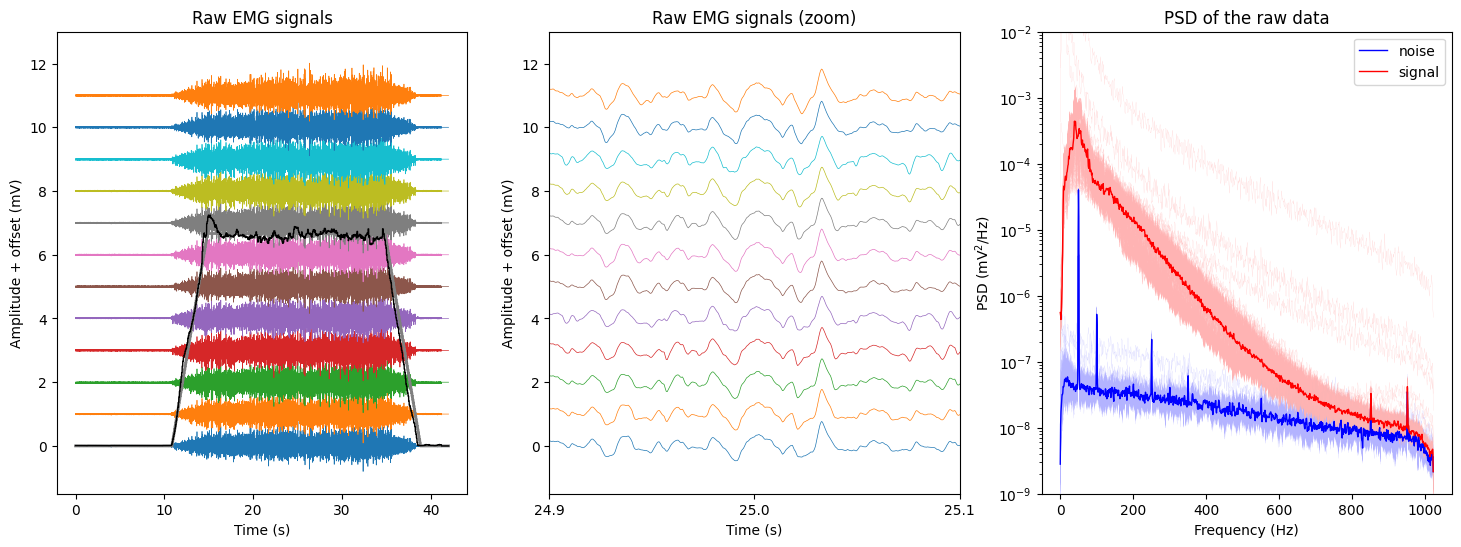

In [59]:
# Get start and end of the task
idx = np.argwhere(requested_path>requested_path[0]+0.5).squeeze()
start_idx = idx[0]
end_idx   = idx[-1]

# Split up the signal into signal and noise 
sig = emg_data[:, start_idx:end_idx]
noise = emg_data[:,:start_idx]

# Calculate the SNR
p_sig = np.mean(sig**2)
p_noise = np.mean(noise**2)
snr = 10 * np.log10(p_sig / p_noise)
print(f"The SNR of the raw signal is {snr} dB.")

# Calculate the RMS of the noise
rms_noise = np.sqrt(np.mean(noise**2))
print(f"The RMS of the raw noise is {rms_noise} mV.")

# Calculate the power spectral density (PSD)
Pn, fn = calc_PSD(noise)
Ps, fs = calc_PSD(sig)

# Plot a few channels from the recording together with the power spectrum
channels = np.arange(13,25)
t = np.linspace(0, (nsamples-1)/fsamp, nsamples)

fig, ax = plt.subplots(1,3, figsize=(18,6))

# Full signal
for i, ch_idx in enumerate(channels):
    trace = emg_data[ch_idx, :]
    ax[0].plot(t,trace + 1 * i, lw=0.5)
ax[0].plot(t,requested_path/3, lw=2, color="gray")
ax[0].plot(t,performed_path/3, lw=1, color="black")    
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude + offset (mV)")
ax[0].set_ylim(-1.5, len(channels) + 1)
ax[0].set_title("Raw EMG signals")
# Now let's focus on some details
for i, ch_idx in enumerate(channels):
    trace = emg_data[ch_idx, :]
    ax[1].plot(t,trace + 1 * i, lw=0.5)  
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude + offset (mV)")
ax[1].set_ylim(-1.5, len(channels) + 1)
ax[1].set_xlim(24.9,25.1)
ax[1].set_xticks([24.9, 25, 25.1])
ax[1].set_title("Raw EMG signals (zoom)")
# Plot the PSD
ax[2].semilogy(fn,Pn.T, lw=0.1, color=[0.7, 0.7, 1])
ax[2].semilogy(fs,Ps.T, lw=0.1, color=[1, 0.7, 0.7])
ax[2].semilogy(fn,np.percentile(Pn, 50, axis=0), lw=1, color="blue", label="noise")
ax[2].semilogy(fs,np.percentile(Ps, 50, axis=0), lw=1, color="red", label="signal")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("PSD (mV$^2$/Hz)")
ax[2].set_ylim(1e-9, 1e-2)
ax[2].legend()
ax[2].set_title("PSD of the raw data")
plt.show()

#### Applying digital filters

The PSD of the raw noise data shows a strong peaks at the power line frequency of 50 Hz. Morover, there is a second order harmonic visible at 100 Hz (as well as a few other peaks that we won't focus on in the following). We will try to reject this power line noise using a notch filter implemented by means of a butterworth filter. 

We also observe that the EMG has the largest energy in a band roughly spanning from 20 to 500 Hz. Assuming that signal components below or above that frequency band are dominated by noise, we will try to further clean the signal using a butterwoth bandpass filter.

We see that here efficiently rejects noise in the considered frequency bands. If these frequencies overlay with the signal (e.g. for the 50 and 100 Hz peak) that comes by the cost of also rejecting parts of the signal.

The SNR of the filtered signal is 31.344450948339833 dB.
The RMS of the filtered noise is 0.004390340764470318 mV.


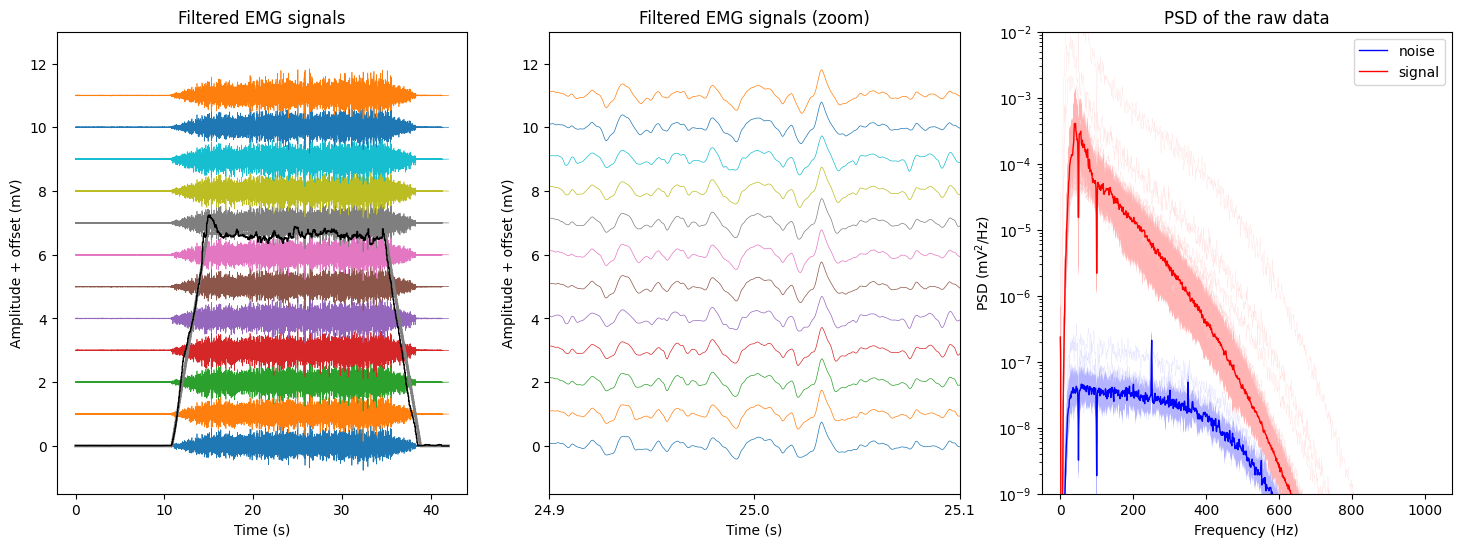

In [ ]:
# Apply a notch filter
filtered_emg = emg_data.copy()
filtered_emg = notch_signals(filtered_emg, fsamp=fsamp, nfreq=pfreq, order=2, n_harmonics=2, ftype="butter")
filtered_emg = bandpass_signals(filtered_emg, fsamp=fsamp, high_pass=20, low_pass=500, order=2, ftype="butter")

# Split up the signal into signal and noise 
sig = filtered_emg[:, start_idx:end_idx]
noise = filtered_emg[:,:start_idx]

# Calculate the SNR
p_sig = np.mean(sig**2)
p_noise = np.mean(noise**2)
snr = 10 * np.log10(p_sig / p_noise)
print(f"The SNR of the filtered signal is {snr} dB.")

# Calculate the RMS of the noise
rms_noise = np.sqrt(np.mean(noise**2))
print(f"The RMS of the filtered noise is {rms_noise} mV.")

# Calculate the power spectral density (PSD)
Pn, fn = calc_PSD(noise)
Ps, fs = calc_PSD(sig)

# Plot a few channels from the recording together with the power spectrum
channels = np.arange(13,25)
t = np.linspace(0, (nsamples-1)/fsamp, nsamples)

fig, ax = plt.subplots(1,3, figsize=(18,6))

# Full signal
for i, ch_idx in enumerate(channels):
    trace = filtered_emg[ch_idx, :]
    ax[0].plot(t,trace + 1 * i, lw=0.5)
ax[0].plot(t,requested_path/3, lw=2, color="gray")
ax[0].plot(t,performed_path/3, lw=1, color="black")    
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude + offset (mV)")
ax[0].set_ylim(-1.5, len(channels) + 1)
ax[0].set_title("Filtered EMG signals")
# Now let's focus on some details
for i, ch_idx in enumerate(channels):
    trace = filtered_emg[ch_idx, :]
    ax[1].plot(t,trace + 1 * i, lw=0.5)  
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude + offset (mV)")
ax[1].set_ylim(-1.5, len(channels) + 1)
ax[1].set_xlim(24.9,25.1)
ax[1].set_xticks([24.9, 25, 25.1])
ax[1].set_title("Filtered EMG signals (zoom)")
# Plot the PSD
ax[2].semilogy(fn,Pn.T, lw=0.1, color=[0.7, 0.7, 1])
ax[2].semilogy(fs,Ps.T, lw=0.1, color=[1, 0.7, 0.7])
ax[2].semilogy(fn,np.percentile(Pn, 50, axis=0), lw=1, color="blue", label="noise")
ax[2].semilogy(fs,np.percentile(Ps, 50, axis=0), lw=1, color="red", label="signal")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("PSD (mV$^2$/Hz)")
ax[2].set_ylim(1e-9, 1e-2)
ax[2].legend()
ax[2].set_title("PSD of the filtered data")
plt.show()

## Filter design

We have now seen that digital filtering (to some degree) helps us cleaning EMG and thus improves the SNR. There exists multiple approaches to filter data and wather a specific filtering choice is good or bad will depend on the raw data as well as your application. Considering motor unit identification an important assumption is that the measured signal is the linear superposition of contributions stemming from the individual motor units. Hence, all filtering approaches implemented in the MUniverse framework are linear filters. The available options are roughly outlined in the following. 

#### Notch filters

Here we provide two different filter types (Butterwoth or fft-based) for removing power line noise (or rejecting any other noise source affecting a narrow frequecny band). Their behavior is showcased in the following.

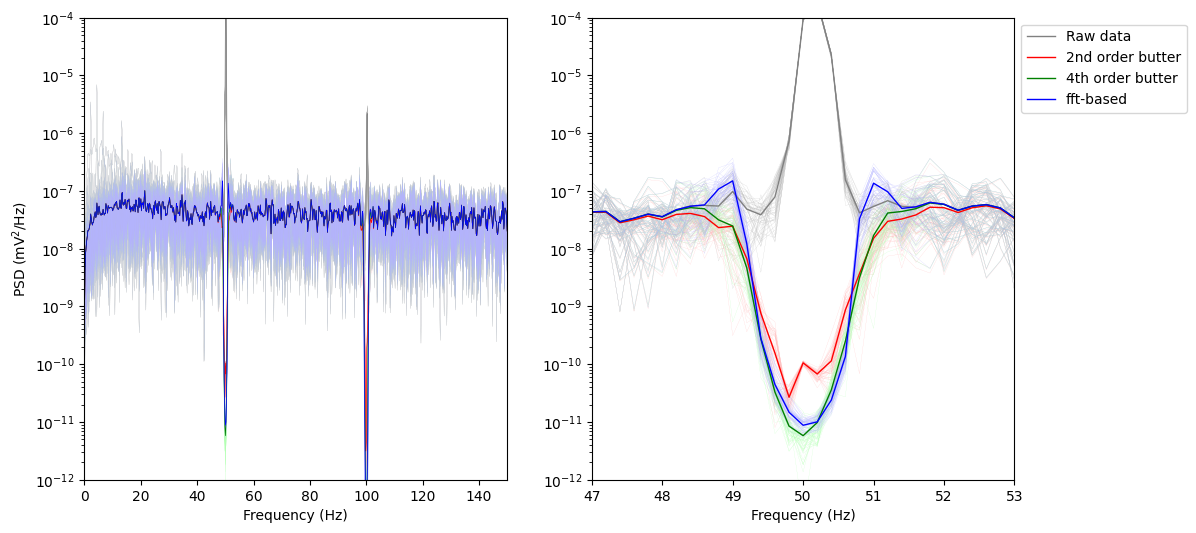

In [ ]:
# Get the noise data
noise = emg_data[:,:start_idx]

# Try different filters
noise_notch_fft = notch_signals(noise, fsamp=fsamp, ftype='fft', dfreq=1.0, n_harmonics=2)
noise_notch_butter2 = notch_signals(noise, fsamp=fsamp, ftype='butter', order=2,n_harmonics=2, dfreq=1)
noise_notch_butter4 = notch_signals(noise, fsamp=fsamp, ftype='butter', order=4,n_harmonics=2, dfreq=1)
noise_notch_iirnotch = notch_signals(noise, fsamp=fsamp, ftype='iirnotch', order=20, n_harmonics=2)

# Estimate the PSD
P_raw, f_raw = calc_PSD(noise, nperseg=5*fsamp, noverlap=fsamp)
P_fft, f_fft = calc_PSD(noise_notch_fft, nperseg=5*fsamp, noverlap=fsamp)
P_b2, f_b2 = calc_PSD(noise_notch_butter2, nperseg=5*fsamp, noverlap=fsamp)
P_b4, f_b4 = calc_PSD(noise_notch_butter4, nperseg=5*fsamp, noverlap=fsamp)

# Plot spectra
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].semilogy(f_raw,P_raw[::5,:].T, lw=0.1, color=[0.7, 0.7, 0.7])
ax[0].semilogy(f_b2,P_b2[::5,:].T, lw=0.1, color=[1, 0.7, 0.7])
ax[0].semilogy(f_b4,P_b4[::5,:].T, lw=0.1, color=[0.7, 1, 0.7])
ax[0].semilogy(f_fft,P_fft[::5,:].T, lw=0.1, color=[0.7, 0.7, 1])
ax[0].semilogy(f_raw,np.mean(P_raw, axis=0), lw=0.5, color="gray", label="Raw data")
ax[0].semilogy(f_b2,np.mean(P_b2, axis=0), lw=0.5, color="red", label="2nd order butter")
ax[0].semilogy(f_b4,np.mean(P_b4, axis=0), lw=0.5, color="green", label="4th order butter")
ax[0].semilogy(f_fft,np.mean(P_fft, axis=0), lw=0.5, color="blue", label="fft-based")
ax[0].set_ylim(1e-12,1e-4)
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("PSD (mV$^2$/Hz)")
ax[0].set_xlim(0, 150)

ax[1].semilogy(f_raw,P_raw[::5,:].T, lw=0.1, color=[0.7, 0.7, 0.7])
ax[1].semilogy(f_b2,P_b2[::5,:].T, lw=0.1, color=[1, 0.7, 0.7])
ax[1].semilogy(f_b4,P_b4[::5,:].T, lw=0.1, color=[0.7, 1, 0.7])
ax[1].semilogy(f_fft,P_fft[::5,:].T, lw=0.1, color=[0.7, 0.7, 1])
ax[1].semilogy(f_raw,np.mean(P_raw, axis=0), lw=1, color="gray", label="Raw data")
ax[1].semilogy(f_b2,np.mean(P_b2, axis=0), lw=1, color="red", label="2nd order butter")
ax[1].semilogy(f_b4,np.mean(P_b4, axis=0), lw=1, color="green", label="4th order butter")
ax[1].semilogy(f_fft,np.mean(P_fft, axis=0), lw=1, color="blue", label="fft-based")
ax[1].set_ylim(1e-12,1e-4)
ax[1].set_xlim(47, 53)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()




- Butterworth filters are solid general pupose filters, due to their smooth transitions particularly for removing borader frequency bands. However, it can also be used as a stop band filter. If you want a very sharp filter, you need to increase the filter oder what can cause numerical instabilities (here when setting the order to a value higher than 4). So when selecting that option you need to balance between sharpness and stability. 
- FFT-based filtering is partiucalrly well suited when extermly precise frequency control is desired (you can design arbitray filters by specifically selecting gains for each frequency bin). Thereby, one needs to be aware that harsh transitions can cause ringing, which is visible in the spectrum as an artifical increase in the PSD of neighburing frequencies.  

#### Bandpass filters

By using lowpass,highpass or bandpass filters one tries to eliminate noise in frequency bands not overlapping with the signal. Surface EMG signals are expected to have a bandwith roughly spanning from ten to several hundrets of Herz. In MUniverse we have curently implemented two types of bandpass filters:

- Firwin2 corresponds to a finite impulse response (FIR) filter. This type of filter allows for relativly sharp cut offs and is numerical stable. The sharpness can be controlled by the length of the filter window ("numtabs"), which also increases the computational cost.
- The butterworth filter is an infinite impulse response (IIR) filter. The cutoffs can be precisly controlled and are rather smooth. Furthermore, a Butterworth filter is computationally efficient. As discussed before, one needs to balance sharpness and numerical stability.

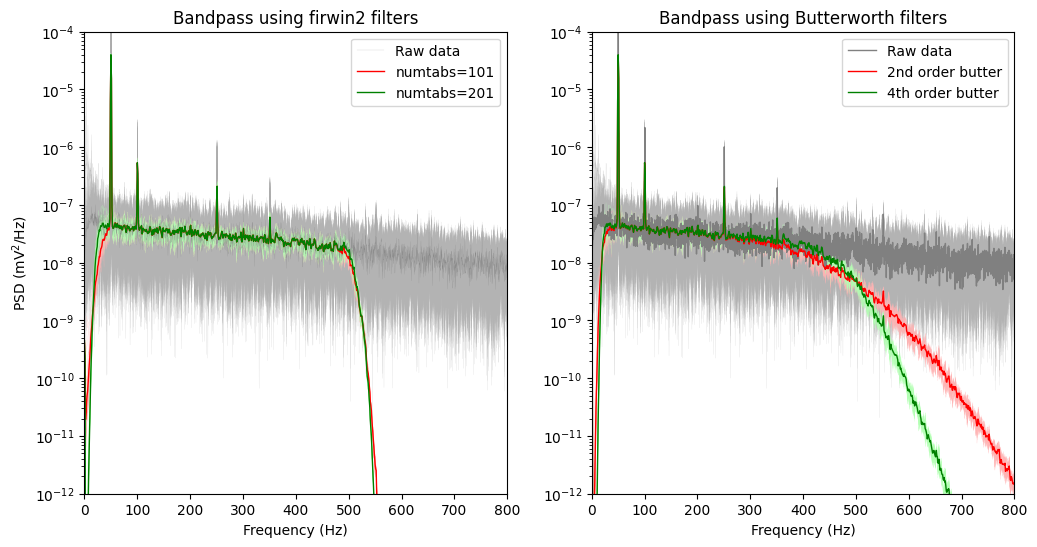

In [73]:
# Get the noise data
noise = emg_data[:,:start_idx]

# Try different filters
noise_firwin201 = bandpass_signals(noise, fsamp=fsamp, ftype='firwin2', order=201)
noise_firwin101 = bandpass_signals(noise, fsamp=fsamp, ftype='firwin2', order=101)
noise_band_butter2 = bandpass_signals(noise, fsamp=fsamp, ftype='butter', order=2)
noise_band_butter4 = bandpass_signals(noise, fsamp=fsamp, ftype='butter', order=4)

P_fw201, f_fw201 = calc_PSD(noise_firwin201)
P_fw101, f_fw101 = calc_PSD(noise_firwin101)
P_b2, f_b2 = calc_PSD(noise_band_butter2)
P_b4, f_b4 = calc_PSD(noise_band_butter4)

# Plot spectra
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].semilogy(f_raw,P_raw[::5,:].T, lw=0.1, color=[0.7, 0.7, 0.7])
ax[0].semilogy(f_fw101,P_fw101[::5,:].T, lw=0.1, color=[1, 0.7, 0.7])
ax[0].semilogy(f_fw201,P_fw201[::5,:].T, lw=0.1, color=[0.7, 1, 0.7])
ax[0].semilogy(f_raw,np.mean(P_raw, axis=0), lw=0.1, color="gray", label="Raw data")
ax[0].semilogy(f_fw101,np.mean(P_fw101, axis=0), lw=1, color="red", label="numtabs=101")
ax[0].semilogy(f_fw201,np.mean(P_fw201, axis=0), lw=1, color="green", label="numtabs=201")
ax[0].set_ylim(1e-12,1e-4)
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("PSD (mV$^2$/Hz)")
ax[0].legend(loc='upper right')
ax[0].set_title("Bandpass using firwin2 filters")
ax[0].set_xlim(0, 800)

ax[1].semilogy(f_raw,P_raw[::5,:].T, lw=0.1, color=[0.7, 0.7, 0.7])
ax[1].semilogy(f_b2,P_b2[::5,:].T, lw=0.1, color=[1, 0.7, 0.7])
ax[1].semilogy(f_b4,P_b4[::5,:].T, lw=0.1, color=[0.7, 1, 0.7])
ax[1].semilogy(f_raw,np.mean(P_raw, axis=0), lw=1, color="gray", label="Raw data")
ax[1].semilogy(f_b2,np.mean(P_b2, axis=0), lw=1, color="red", label="2nd order butter")
ax[1].semilogy(f_b4,np.mean(P_b4, axis=0), lw=1, color="green", label="4th order butter")
ax[1].set_ylim(1e-12,1e-4)
ax[1].set_xlim(0, 800)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].legend(loc='upper right')
ax[1].set_title("Bandpass using Butterworth filters")
plt.show()
